In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
folder_paths = [x[0] for x in os.walk('/content/drive/MyDrive/Skripsi/GAN')]

In [ ]:
folder_paths

['/content/drive/MyDrive/Skripsi/GAN',
 '/content/drive/MyDrive/Skripsi/GAN/0',
 '/content/drive/MyDrive/Skripsi/GAN/1',
 '/content/drive/MyDrive/Skripsi/GAN/2',
 '/content/drive/MyDrive/Skripsi/GAN/3',
 '/content/drive/MyDrive/Skripsi/GAN/4',
 '/content/drive/MyDrive/Skripsi/GAN/5']

In [ ]:
# Extract the artist names from the paths
artists = [os.path.basename(path).replace('_', ' ') for path in folder_paths[1:]]

# Print the list of artists
print(artists)

['0', '1', '2', '3', '4', '5']


In [ ]:
DATA_DIR = '/content/paintings/images'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      src_path = os.path.join(folder_path, filename)
      dst_path = os.path.join(DATA_DIR, filename)
      shutil.copy(src_path, dst_path)

In [ ]:
valid_extensions = ('.jpg', '.png')

# Get the list of all files in the folder with valid extensions
files = [file for file in os.listdir(DATA_DIR) if file.endswith(valid_extensions)]

# Print the total number of images in the folder
print(f'Total number of images in {DATA_DIR}: {len(files)}')

Total number of images in /content/paintings/images: 57838


In [ ]:
print(os.listdir(DATA_DIR)[:10])

['cs1416079017964514624.jpg', 'cs13129418041517285155.jpg', 'cs11642271500921945281.jpg', 'cs2423159578819388102.jpg', 'cs13240397482063270707.jpg', 'cs16102299904276718846.jpg', 'cs3925428940012020560.jpg', 'cs2448848613852561012.jpg', 'cs13074707230251676205.jpg', 'cs12860897457959625157.jpg']


In [ ]:
from PIL import Image

def checkDimensions(fname):
  image = Image.open(DATA_DIR+'/'+fname)
  width, height = image.size
  print(f"The shape of the image is {width}x{height}")

In [ ]:
# checkDimensions('Albrecht_DuGòá+¬rer_103.jpg'), checkDimensions('Albrecht_DuGòá+¬rer_107.jpg')

In [ ]:
folder_path = DATA_DIR

total_width = 0
total_height = 0
num_images = 0

# loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # open the image
        image = Image.open(os.path.join(folder_path, filename))

        # get the shape (dimensions) of the image
        width, height = image.size

        # accumulate the total width and height
        total_width += width
        total_height += height

        # increment the number of images
        num_images += 1

# calculate the mean dimensions
mean_width = total_width / num_images
mean_height = total_height / num_images

# print the mean dimensions
print(f"The mean dimensions of the {num_images} images are {mean_width}x{mean_height}")

The mean dimensions of the 57838 images are 500.0x500.0


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
""" I have tried increasing the image size and networks, but due to limitations of Google Colab, it was not feasible."""
image_size = 32
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder('/content/paintings', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

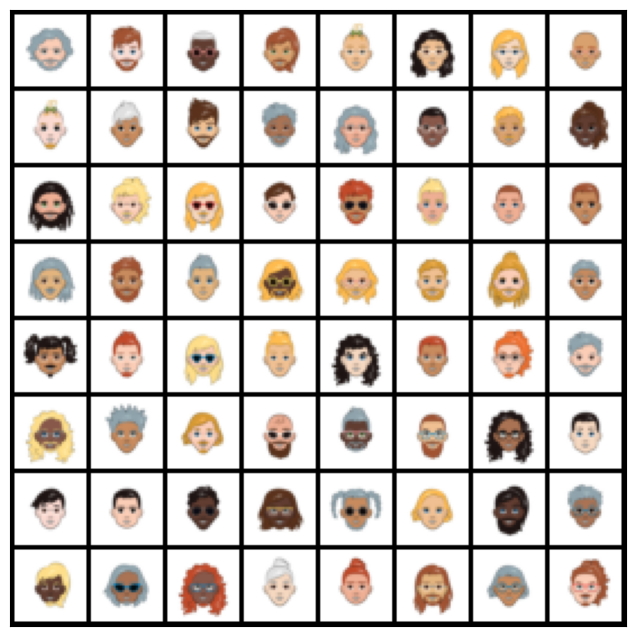

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 32 x 32

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 2 x 2

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 1 x 1

    nn.Conv2d(1024, 1, kernel_size=1, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=1, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 1 x 1

    nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 2 x 2

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 8 x 8

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 16 x 16

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 32 x 32
)


torch.Size([128, 3, 32, 32])


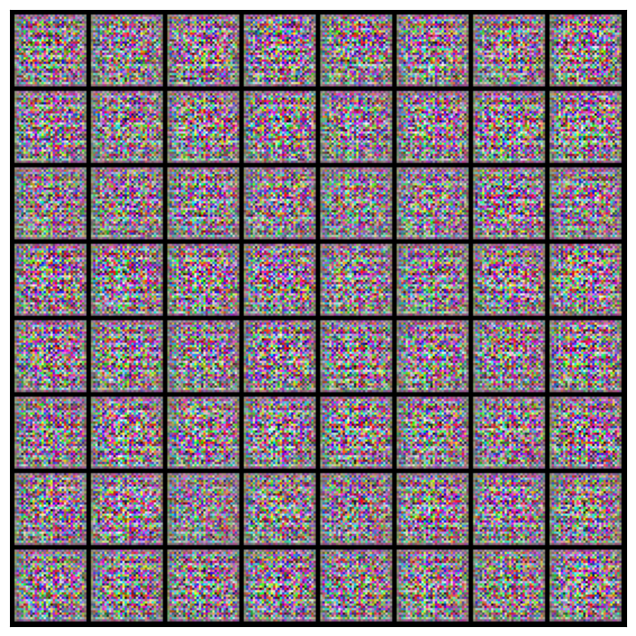

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


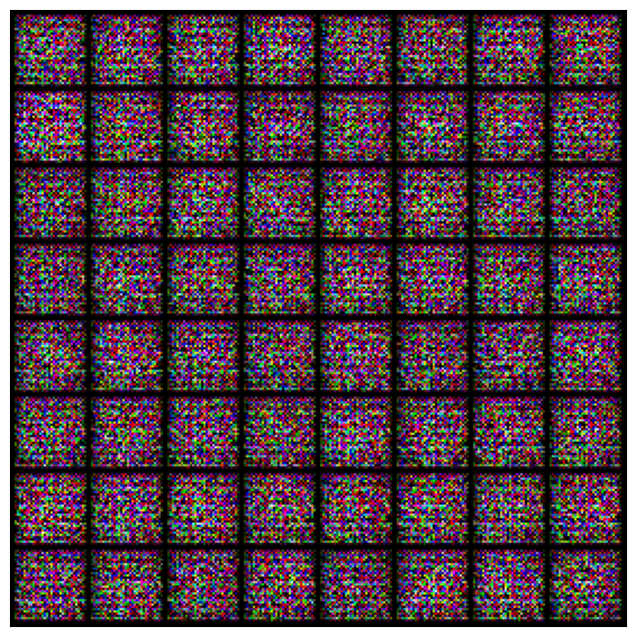

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.0077, loss_d: 0.2193, real_score: 0.9673, fake_score: 0.1683
Saving generated-images-0001.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 2.9316, loss_d: 0.0709, real_score: 0.9872, fake_score: 0.0562
Saving generated-images-0002.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.0721, loss_d: 0.1520, real_score: 0.8882, fake_score: 0.0209
Saving generated-images-0003.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 4.2849, loss_d: 0.0186, real_score: 0.9958, fake_score: 0.0142
Saving generated-images-0004.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.7637, loss_d: 0.0140, real_score: 0.9952, fake_score: 0.0091
Saving generated-images-0005.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.8061, loss_d: 0.0100, real_score: 0.9989, fake_score: 0.0088
Saving generated-images-0006.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.0371, loss_d: 0.0080, real_score: 0.9994, fake_score: 0.0074
Saving generated-images-0007.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.7141, loss_d: 0.0184, real_score: 0.9909, fake_score: 0.0092
Saving generated-images-0008.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 5.7780, loss_d: 0.0067, real_score: 0.9969, fake_score: 0.0036
Saving generated-images-0009.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.4615, loss_d: 0.0056, real_score: 0.9990, fake_score: 0.0046
Saving generated-images-0010.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 6.0247, loss_d: 0.0029, real_score: 0.9997, fake_score: 0.0026
Saving generated-images-0011.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 6.5638, loss_d: 0.0029, real_score: 0.9989, fake_score: 0.0018
Saving generated-images-0012.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 5.7607, loss_d: 0.0044, real_score: 0.9991, fake_score: 0.0035
Saving generated-images-0013.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 5.6213, loss_d: 0.0042, real_score: 0.9998, fake_score: 0.0040
Saving generated-images-0014.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.4655, loss_d: 0.0022, real_score: 0.9995, fake_score: 0.0017
Saving generated-images-0015.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 6.7253, loss_d: 0.0110, real_score: 0.9905, fake_score: 0.0013
Saving generated-images-0016.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 6.8043, loss_d: 0.0016, real_score: 0.9996, fake_score: 0.0012
Saving generated-images-0017.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.1627, loss_d: 0.0061, real_score: 0.9964, fake_score: 0.0024
Saving generated-images-0018.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.3154, loss_d: 0.0028, real_score: 0.9998, fake_score: 0.0025
Saving generated-images-0019.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.9004, loss_d: 0.0035, real_score: 0.9981, fake_score: 0.0017
Saving generated-images-0020.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 8.0550, loss_d: 0.0008, real_score: 0.9997, fake_score: 0.0006
Saving generated-images-0021.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 7.4282, loss_d: 0.1514, real_score: 0.9952, fake_score: 0.0723
Saving generated-images-0022.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.8285, loss_d: 0.0061, real_score: 0.9953, fake_score: 0.0013
Saving generated-images-0023.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 7.4883, loss_d: 0.0008, real_score: 0.9999, fake_score: 0.0007
Saving generated-images-0024.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 7.4608, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0025.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 7.5388, loss_d: 0.0010, real_score: 0.9996, fake_score: 0.0006
Saving generated-images-0026.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 7.6318, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006
Saving generated-images-0027.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 7.2382, loss_d: 0.0024, real_score: 0.9985, fake_score: 0.0008
Saving generated-images-0028.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 7.9758, loss_d: 0.0008, real_score: 0.9996, fake_score: 0.0004
Saving generated-images-0029.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 7.2005, loss_d: 0.0015, real_score: 0.9996, fake_score: 0.0011
Saving generated-images-0030.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 7.8550, loss_d: 0.0006, real_score: 0.9999, fake_score: 0.0005
Saving generated-images-0031.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 7.8501, loss_d: 0.0590, real_score: 0.9987, fake_score: 0.0468
Saving generated-images-0032.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 7.7492, loss_d: 0.0022, real_score: 0.9990, fake_score: 0.0013
Saving generated-images-0033.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 7.4285, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0007
Saving generated-images-0034.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 7.4949, loss_d: 0.0007, real_score: 1.0000, fake_score: 0.0007
Saving generated-images-0035.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 8.1476, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0005
Saving generated-images-0036.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 8.0206, loss_d: 0.0011, real_score: 0.9997, fake_score: 0.0008
Saving generated-images-0037.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 8.5562, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0038.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 8.7137, loss_d: 0.0006, real_score: 0.9997, fake_score: 0.0002
Saving generated-images-0039.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 7.6634, loss_d: 0.0010, real_score: 0.9995, fake_score: 0.0005
Saving generated-images-0040.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 8.5885, loss_d: 0.0007, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-0041.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 8.4108, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0042.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 8.2092, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0043.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 8.5195, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-0044.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 8.7445, loss_d: 0.0118, real_score: 0.9887, fake_score: 0.0002
Saving generated-images-0045.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 9.4005, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-0046.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 8.2639, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-0047.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 10.0910, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0002
Saving generated-images-0048.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 8.6663, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0049.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 8.8626, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

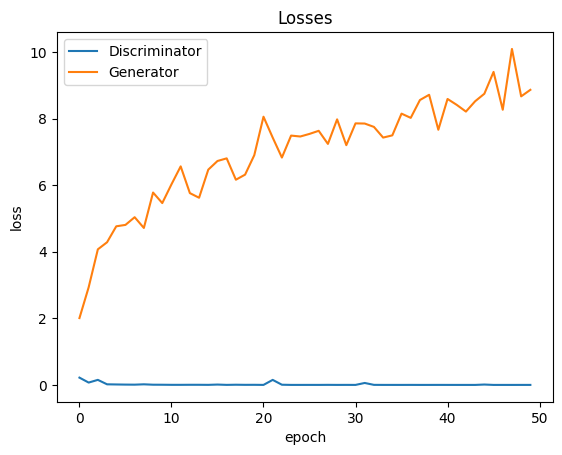

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

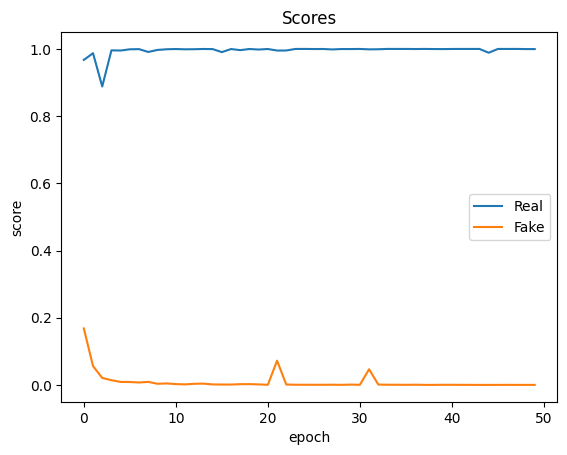

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
!zip -r /content/generated.zip /content/generated
from google.colab import files

files.download("/content/generated.zip")

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0030.png (deflated 0%)
  adding: content/generated/generated-images-0000.png (deflated 0%)
  adding: content/generated/generated-images-0044.png (deflated 1%)
  adding: content/generated/generated-images-0029.png (deflated 1%)
  adding: content/generated/generated-images-0010.png (deflated 0%)
  adding: content/generated/generated-images-0047.png (deflated 1%)
  adding: content/generated/generated-images-0002.png (deflated 1%)
  adding: content/generated/generated-images-0032.png (deflated 1%)
  adding: content/generated/generated-images-0009.png (deflated 0%)
  adding: content/generated/generated-images-0025.png (deflated 1%)
  adding: content/generated/generated-images-0016.png (deflated 0%)
  adding: content/generated/generated-images-0011.png (deflated 0%)
  adding: content/generated/generated-images-0007.png (deflated 0%)
  adding: content/generated/generated-images-0008.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/D.pth')
files.download('/content/G.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>